## Ploting

## Plot forecasting residuals


Analyzing the residuals (errors) of predictions is useful to understand the behavior of a forecaster. The function `skforecast.plot.plot_residuals` creates 3 plots:

+ A time-ordered plot of residual values

+ A distribution plot that showcases the distribution of residuals

+ A plot showcasing the autocorrelation of residuals

By examining the residual values over time, you can determine whether there is a pattern in the errors made by the forecast model. The distribution plot helps you understand whether the residuals are normally distributed, and the autocorrelation plot helps you identify whether there are any dependencies or relationships between the residuals.

In [10]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_residuals
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


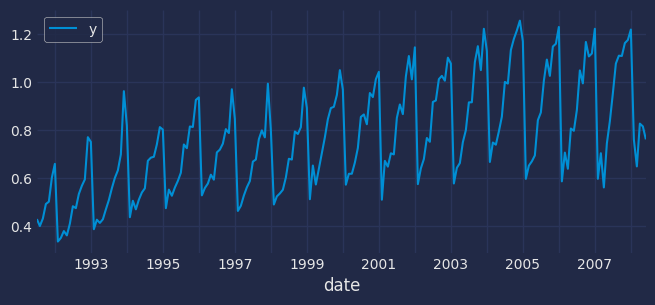

In [11]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "date"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')

# Plot data
# ==============================================================================
set_dark_theme()
fig, ax=plt.subplots(figsize=(7, 3))
data.plot(ax=ax);

In [12]:
# Train and backtest forecaster
# ==============================================================================
n_backtest = 36*3
data_train = data[:-n_backtest]
data_test  = data[-n_backtest:]

forecaster = ForecasterAutoreg(
                 regressor = Ridge(),
                 lags      = 5 
             )

metric, predictions = backtesting_forecaster(
                        forecaster         = forecaster,
                        y                  = data.y,
                        initial_train_size = len(data_train),
                        steps              = 36,
                        metric             = 'mean_squared_error',
                        verbose            = True
                     )
 
predictions.head()

Information of backtesting process
----------------------------------
Number of observations used for initial training: 96
Number of observations used for backtesting: 108
    Number of folds: 3
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00  (n=96)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00  (n=96)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00  (n=96)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

,pred
1999-07-01,0.667651
1999-08-01,0.655759
1999-09-01,0.652177
1999-10-01,0.641377
1999-11-01,0.635245


The `plot_residuals` function can be used in two ways: with pre-calculated residuals or by passing the predicted and actual values of the series.

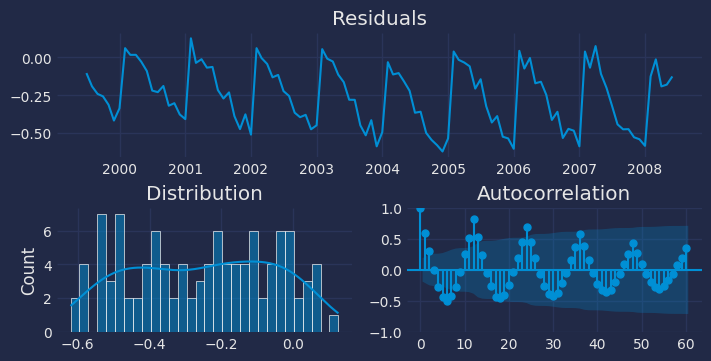

In [13]:
# Plot residuals
# ======================================================================================
residuals = predictions['pred'] - data_test['y']
_ = plot_residuals(residuals=residuals, figsize=(7, 3.5))

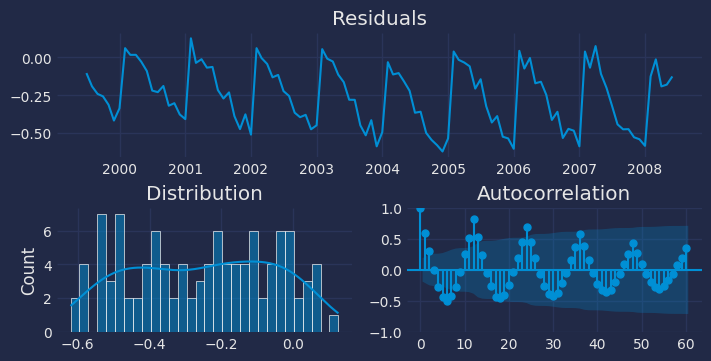

In [14]:
_ = plot_residuals(y_true=data_test['y'], y_pred=predictions['pred'], figsize=(7, 3.5))

It is possible to customize the plot by by either passing a pre-existing matplotlib figure object or using additional keyword arguments that are passed to `matplotlib.pyplot.figure()`.

## Plot prediction intervals

In [15]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.plot import plot_prediction_intervals

In [16]:
# Data download
# ==============================================================================
data = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Data preparation
# ==============================================================================
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('MS')
data = data.sort_index()

# Split data into train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]
print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Test dates  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


In [17]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = Ridge(alpha=0.1, random_state=765),
                 lags      = 15
             )
forecaster.fit(y=data_train['y'])

# Prediction intervals
# ==============================================================================
predictions = forecaster.predict_interval(
                  steps    = steps,
                  interval = [1, 99],
                  n_boot   = 500
              )

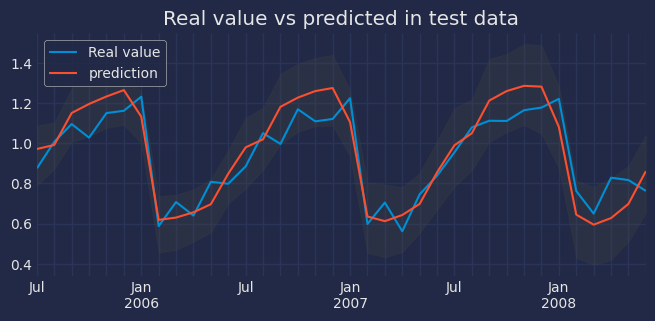

In [18]:
# Plot forecasts with prediction intervals
# ==============================================================================
plot_prediction_intervals(
    predictions     = predictions,
    y_true          = data_test,
    target_variable = "y",
    title           = "Real value vs predicted in test data"
)